# TML Assignment 3
Roll no : 20171002 $\newline$
Name : Soumyasis Gun $\newline$
## Policy Gradient Methods on Continuous Action Spaces

##### Import Libraries:

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from ActorCriticModels import *
from utilities import *
from PendulumAgent import *
from DDPG import *

In this notebook we are going to look at the following tasks for the continuous Action Space:

Demonstrate the efficacy of the following family of algorithms in both environments and compare amongst the variations.
1. Vanilla Policy Gradient [2x10 points] Learn the set of parameters θ which approximates the function π(a|s; θ) to obtain “expected” maximum return.
2. Policy Gradients with Baselines [2x10 points] Ensure your baselines are not learnt in this case. Justify the baselines you have put in place. Compare the variance in rewards versus Vanilla Policy Gradient.
3. Actor-Critic Method [2x10 points]: In this method, you have to train an additional network (again function approximation) to predict a state dependent baseline - V (s; θ b ).
4. Gaussian Policy [10 points] It’s often advantageous to predict a range of actions in the continuou space which are favourable rather than a single action 1 . Demonstrate a functioning Gaussian Policy network in the suitable environment for the same. Compare training and test dynamics and comment on the observations with a case where the solution predicts only the mean.

## Pendulum Swingup Control Problem

<center>
    <img src="./Assets/pendulum.gif" align:center>
</center>
    
The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

### Action space (Continuous)
* 0- The torque applied on the pendulum, Range: (-2, 2)

### State space (Continuous)
* 0- Pendulum angle
* 1- Pendulum speed

The default reward function depends on the angle of the pendulum. If the pendulum is upright, it will give maximum rewards. 

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if you know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving
$$
a^*(s) = \arg \max_a Q^*(s,a).
$$
In DDPG there are two networks called Actor and Critic. Actor-network output action value, given states to it. Critic network output the Q value (how good state-action pair is), given state and action(produces to by the actor-network) value pair.

In [2]:
env = gym.make('Pendulum-v0')

### Vanilla Policy Gradient(VPG)

- In vanilla policy gradient, we try to train our neural network in such a way so as to maximize the loss function given below:
\begin{equation}
    \max_{\theta}J(\theta) = \sum_{\tau} P(\tau;\theta)R(\tau)
\end{equation}

where $\tau$ is the trajectory that we have sampled, $P(\tau;\theta)$ is the probability of trajectory $\tau$ and $R(\tau)$ is the reward corresponding to the trajectory $\tau$.
- Differntiating the above equation wrt $\theta$ gives the gradient of the objective function.Then we can easily apply Gradient ascent to maximize our objective function.

\begin{equation}
    \nabla_{\theta} J(\theta) = E[\nabla_{\theta} \log\pi_{\theta}(\tau)r(\tau)] \\ \approx \frac{1}{N}\sum_{i=1}^{N}\bigg(\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_{i,t}|s_{i,t})\bigg)\bigg(\sum_{t=1}^{T}r(s_{i,t}|a_{i,t})\bigg)
\end{equation}
- Implementation details:
    - First we play/sample a random episode on the basis of the current policy.
    - Then we compute the discounted rewards and the corresponding gradient of objective function.
    - Then we backpropagate this loss.
    
- The agent becomes trained in $\approx$ 3000 epochs. 

*Note: As we can see,that procedure followed in Gaussian Policy is exactly same as that followed in Vanilla Policy Gradient, so we donot need to write separate code for Gaussian Policy Gradient.*

### VPG without baseline

In [3]:
agent = Pendulum_Agent(env)
reward_history = agent.train(max_episodes=10000,baseline=False)

Episode: 10000, Episode Reward: [-1623.5671], Average Reward: -1419.6901855468755

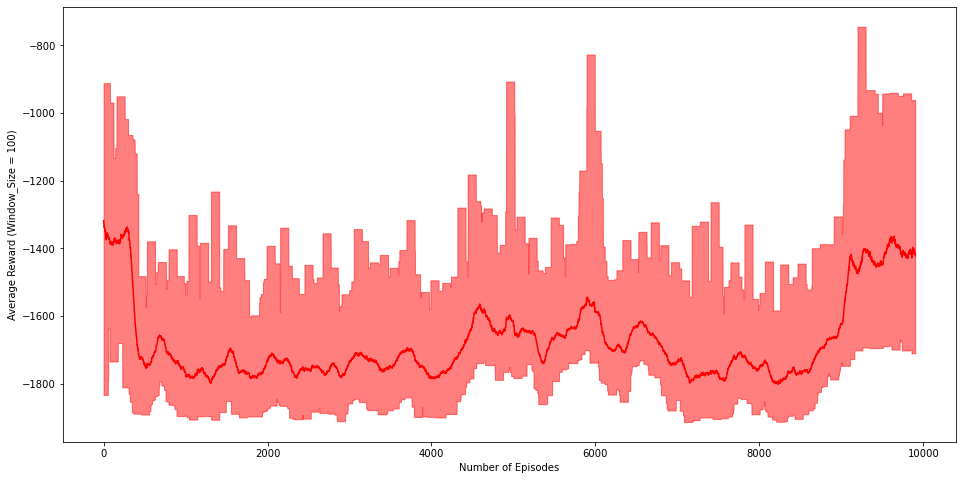

In [4]:
window_size = 100
average, min_returns, max_returns = return_stats(reward_history,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Length of Episodes v/s Number of Episodes

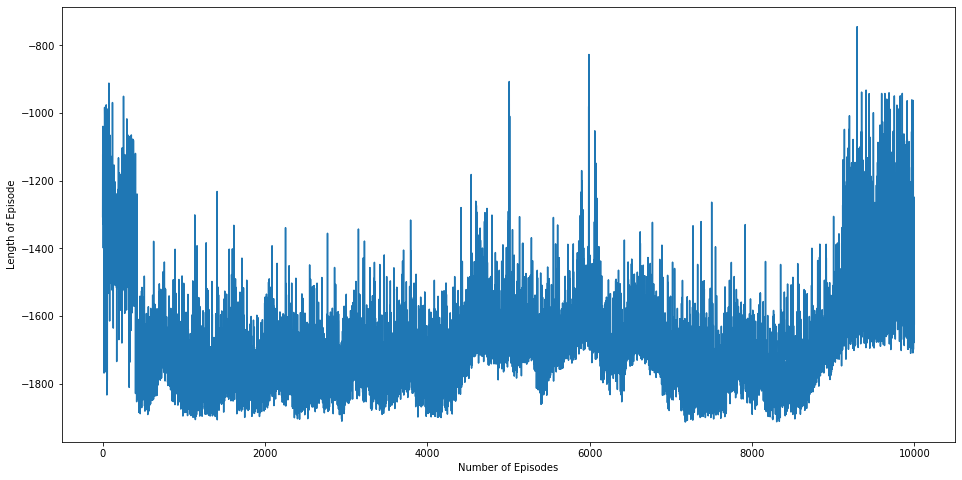

In [5]:
plt.figure(figsize = (16,8))
plt.plot(reward_history)
plt.ylabel("Length of Episode")
plt.xlabel("Number of Episodes")
plt.show()

### Testing

In [6]:
for i in range(10):
    test(agent,env,False)


-915.5620938950899

-1276.5341670764708

-1654.1551754945435

-1332.5061076240643

-1511.3377250378123

-1516.960467764143

-1147.5951803167254

-1658.821703746832

-1482.406899423148

-1339.100399350389


### VPG with baseline

Baseline $b = mean(\;discounted\;rewards\;)$ in the Vanilla Policy gradient as given above.

In [7]:
agent_b = Pendulum_Agent(env)
reward_history_b = agent_b.train(max_episodes = 10000,baseline = True)

Episode: 10000, Episode Reward: [-1293.6835], Average Reward: -1373.405761718755

### Average Reward of Episodes v/s Number of Episodes

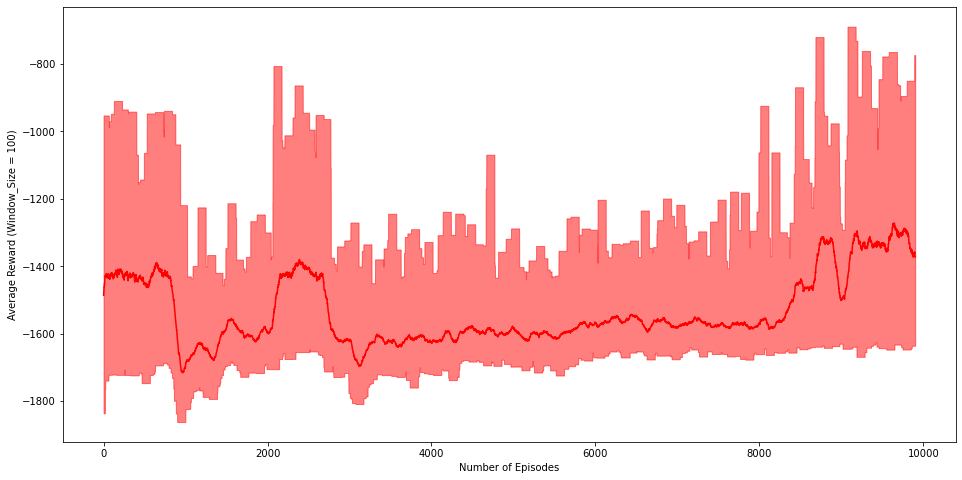

In [8]:
window_size = 100
average, min_returns, max_returns = return_stats(reward_history_b,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Length of Reward v/s Number of Episodes.

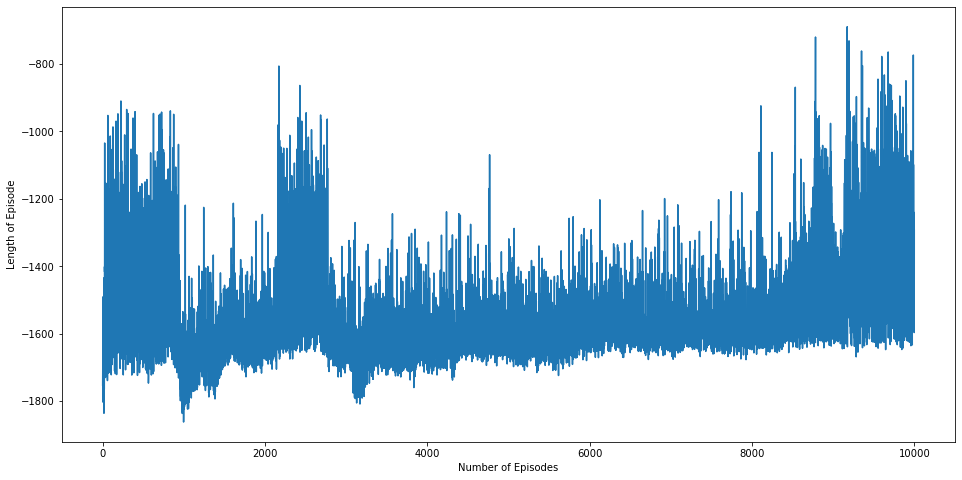

In [9]:
plt.figure(figsize = (16,8))
plt.plot(reward_history_b)
plt.ylabel("Length of Episode")
plt.xlabel("Number of Episodes")
plt.show()

### Testing

In [10]:
for i in range(10):
    test(agent_b,env,False)


-1312.1168537080748

-1470.1023484858458

-1351.8417508015186

-1390.6130424428761

-1617.358472775338

-1278.151905740317

-1434.1586320538368

-1357.6875171251788

-1383.320759483666

-1551.6329076819943


### Actor-Critic Method 

Actor Critic Algorithm takes various forms based on the baseline chosen.
- Q Actor-Critic
\begin{equation}
    \nabla_{\theta}J(\theta) = E[\nabla_{\theta}\log\pi_{\theta}(s,a)Q^{w}(s,a)]
\end{equation}
- Advantage Actor Critic
\begin{equation}
    \nabla_{\theta}J(\theta) = E[\nabla_{\theta}\log\pi_{\theta}(s,a)A^{w}(s,a)]
\end{equation}
- In Actor-Critic Methods,
    * The "Critic" estimates the value function.This could be the action-value ($Q$ value) or the state-value ($v$ value)
    * The "Actor" updates the policy distribution in the direction suggested by the Critic. 
- Advantage-Actor Critic Method has the gradient of the objective function as follows:
\begin{equation}
   \nabla_{\theta}J(\theta) \approx \sum_{t=0}^{T-1}\nabla_{theta}\log\pi_{\theta}(a_{t}|s_{t})A(s_{t},a_{t})
\end{equation}
where,
\begin{equation}
    A(s_{t},a_{t}) = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

In [3]:
agent = DDPG(env,learning_rate=1e-4)
reward_history = agent.train(max_timesteps=3e4)

/home/soumyasis/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/soumyasis/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 149, Episode Reward: -1.1885722141814434, Average Reward: -885.90107783418916

### Average Rewards v/s Number of Episodes

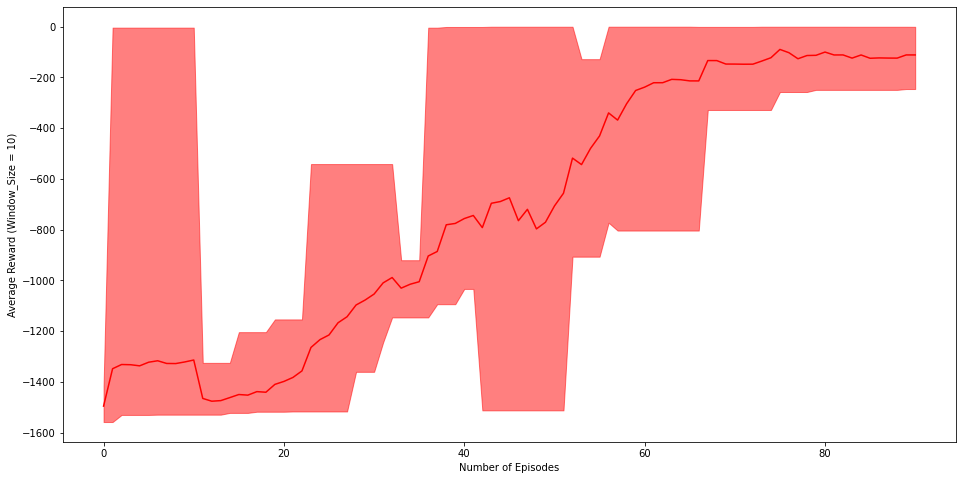

In [4]:
reward_history = reward_history[50:]
window_size = 10
average, min_returns, max_returns = return_stats(reward_history,window_size)
plt.figure(figsize = (16,8))
plot_mean_confInterv(average,min_returns,max_returns,'r','r')
plt.xlabel("Number of Episodes")
plt.ylabel("Average Reward (Window_Size = {})".format(window_size))
plt.show()

### Testing

In [5]:
for i in range(10):
    test(agent,env,False)


-0.2985627234266918

-117.18727088654182

-127.02887335282938

-130.02892312370273

-0.30395726861647293

-0.2886267212390214

-267.8747168429612

-251.66251518591858

-251.86450689051708

-119.51209128212957
